----

![Virus Diagram](images/virusbanner.jpg)
# COVID-19 Data Visualization Notebook 
#### Development Team: 
Equipo F (Cecilia Acosta, Luis Bonilla, Felipe Murillo)
#### Date: 
May 2020
#### Overview
This notebook creates data visualizations of COVID-19 mortality data compared to global monetary measures.

#### Required Inputs:
- **Master COVID Research.csv**

#### Outputs:
All images are saved to the ./outputs/ Folder
- outliers.png
- Health Exp vs Hospital Beds.png
- Health Exp vs Mortality Rate1.png
- Health Exp vs Mortality Rate2.png
- HB vs Regions wSamples.png
- HB vs Cases.png
- GNI vs HB.png
- rvalue_matrix.png


----
### Configure Dependencies

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import gmaps
import os
import scipy.stats as st
from config import gkey

#To create a simple, stand-alone HTML page
from ipywidgets.embed import embed_minimal_html

#Configure gmaps
gmaps.configure(api_key=gkey)

# Seaborn makes very pretty charts based on matplotlib
import seaborn as sns

----
### Import master dataset containing team investigation

In [2]:
# Specify CSV file containing COVID-19 data
master_data_location = os.path.join(".","outputs/Master COVID Research.csv")

# Import CSV file as Dataframe
master_data = pd.read_csv(master_data_location)

In [3]:
# Create COVID mortality rate (CumDeath/CumCase)
mortality = master_data["CumDeath"]/master_data["CumCase"]
master_data["COVID Mortality Rate"] = round(mortality,5)
master_data.head(3)

,Country,Code,Region,Location,Hospital Beds,GNI Per Capita,CumCase,CumDeath,IncomeGroup,Health Expenditure per capita (current USD),Health Expenditure (% of GDP),COVID Mortality Rate
0,Afghanistan,AFG,Eastern Mediterranean,"[33.0, 65.0]",5.0,510.0,3224.0,95.0,Low income,67.122650,11.777194,0.02947
1,Albania,ALB,Europe,"[41.0, 20.0]",29.0,4360.0,803.0,31.0,Upper middle income,NaN,NaN,0.03861
2,Algeria,DZA,Africa,"[28.0, 3.0]",19.0,4480.0,4648.0,465.0,Upper middle income,258.494293,6.374322,0.10004


### Mapping Countries with high COVID-19 Mortality Rates
----

In [4]:
# Parse out country locations (lat, lng) from string

# Initialize latitude and longitude lists
country_lats = []
country_lngs = []

# Grab each entry from each country (note: master dataset lists location as a string)
for country in np.arange(0,len(master_data.index),1):
    country_lats.append(float(master_data.loc[country,"Location"].strip('][').split(', ')[0]))
    country_lngs.append(float(master_data.loc[country,"Location"].strip('][').split(', ')[1]))

# Construct location dataframe
locations_df = pd.DataFrame({"Country":master_data["Country"],
                             "Lat": country_lats,
                             "Lng": country_lngs,
                             "Total Cases": master_data["CumCase"],
                             "Total Deaths": master_data["CumDeath"],
                             "Mortality Rate": master_data["COVID Mortality Rate"]})

In [5]:
# Create the heatmap layer using mortality rate (%) as weight
heatmap_layer = gmaps.heatmap_layer(locations_df[["Lat","Lng"]],
                                    weights = locations_df["Mortality Rate"]*100,
                                    max_intensity = locations_df["Mortality Rate"].max()*100-20,
                                    point_radius = 20)

In [6]:
# Get top countries with high mortality rates
nTop = 15
top = locations_df.sort_values(by="Mortality Rate", ascending = False).head(nTop)

# Create info boxes for symbol layer
info_box_template = """
<dl>
<dt>Country Name</dt><dd>{Country}</dd>
<dt>Mortality Rate</dt><dd>{Mortality Rate:.0%}</dd>
</dl>
"""
# Pull country info from dataframe
country_info = [info_box_template.format(**row) for index, row in top.iterrows()]

# Create the symbol layer of top deadliest countries
top_deadly_layer = gmaps.symbol_layer(top[["Lat","Lng"]],
                                      info_box_content=country_info,
                                      scale = 3,
                                      fill_color='white', 
                                      stroke_color='black',
                                      fill_opacity=1,
                                      stroke_opacity=0.5)

# Display the countries with highest mortality rates
top.head(15)

,Country,Lat,Lng,Total Cases,Total Deaths,Mortality Rate
113,Nicaragua,13.000000,-85.000000,15.0,5.0,0.33333
36,Comoros,-12.166667,44.250000,4.0,1.0,0.25000
58,France,46.000000,2.000000,130242.0,25165.0,0.19322
15,Belgium,50.833333,4.000000,50267.0,7924.0,0.15764
160,United Kingdom,54.000000,-2.000000,190588.0,28734.0,0.15077
167,"Yemen, Rep.",15.000000,48.000000,21.0,3.0,0.14286
80,Italy,42.833333,12.833333,211938.0,29079.0,0.13721
10,"Bahamas, The",24.250000,-76.000000,83.0,11.0,0.13253
101,Mauritania,20.000000,-12.000000,8.0,1.0,0.12500
111,Netherlands,52.500000,5.750000,40770.0,5082.0,0.12465


In [7]:
# Create a google map of the world 
fig1 = gmaps.figure(map_type="HYBRID",
                   center=(20, 0), 
                   zoom_level=2
                  )
# Add layers depicting mortality rates and deadliest countries
fig1.add_layer(heatmap_layer)
fig1.add_layer(top_deadly_layer)

#Display the figure
fig1

Figure(layout=FigureLayout(height='420px'))

### Big Picture: Outliers in COVID-19 indicators
---

In [8]:
# Create function to create strip plot and box plot overlay 
def make_plots(x_series, y_series, y_label, dataframe, ax, ylim):
    
   # Create strip plot
    sns.stripplot(y=y_series, x=x_series, 
                   data=dataframe, 
                   jitter=True,
                   marker='o', 
                   alpha=0.75,
                   ax=ax)

    # Create box plot; fliersize = 0 (to prevent double plotting outliers)
    sns.boxplot(y=y_series, x=x_series, data=dataframe,ax=ax, fliersize = 0)
    
    # Make box plot colors transparent (essentially accomplishing alpha color function)
    for patch in ax.artists:
         r, g, b, a = patch.get_facecolor()
         patch.set_facecolor((r, g, b, .15))


    # Format plot
    ax.set_xlabel("")
    ax.set_ylabel(y_label,fontweight="bold")
    ax.set_ylim(0, ylim)
    ax.grid(alpha = 0.25)

# Create function to label outliers
def label_pts (ax, x_list, y_list, labels):
    for x,y,z in zip(x_list,y_list,labels):
        ax.text(x, y, z, horizontalalignment='left', size='small', color='black')


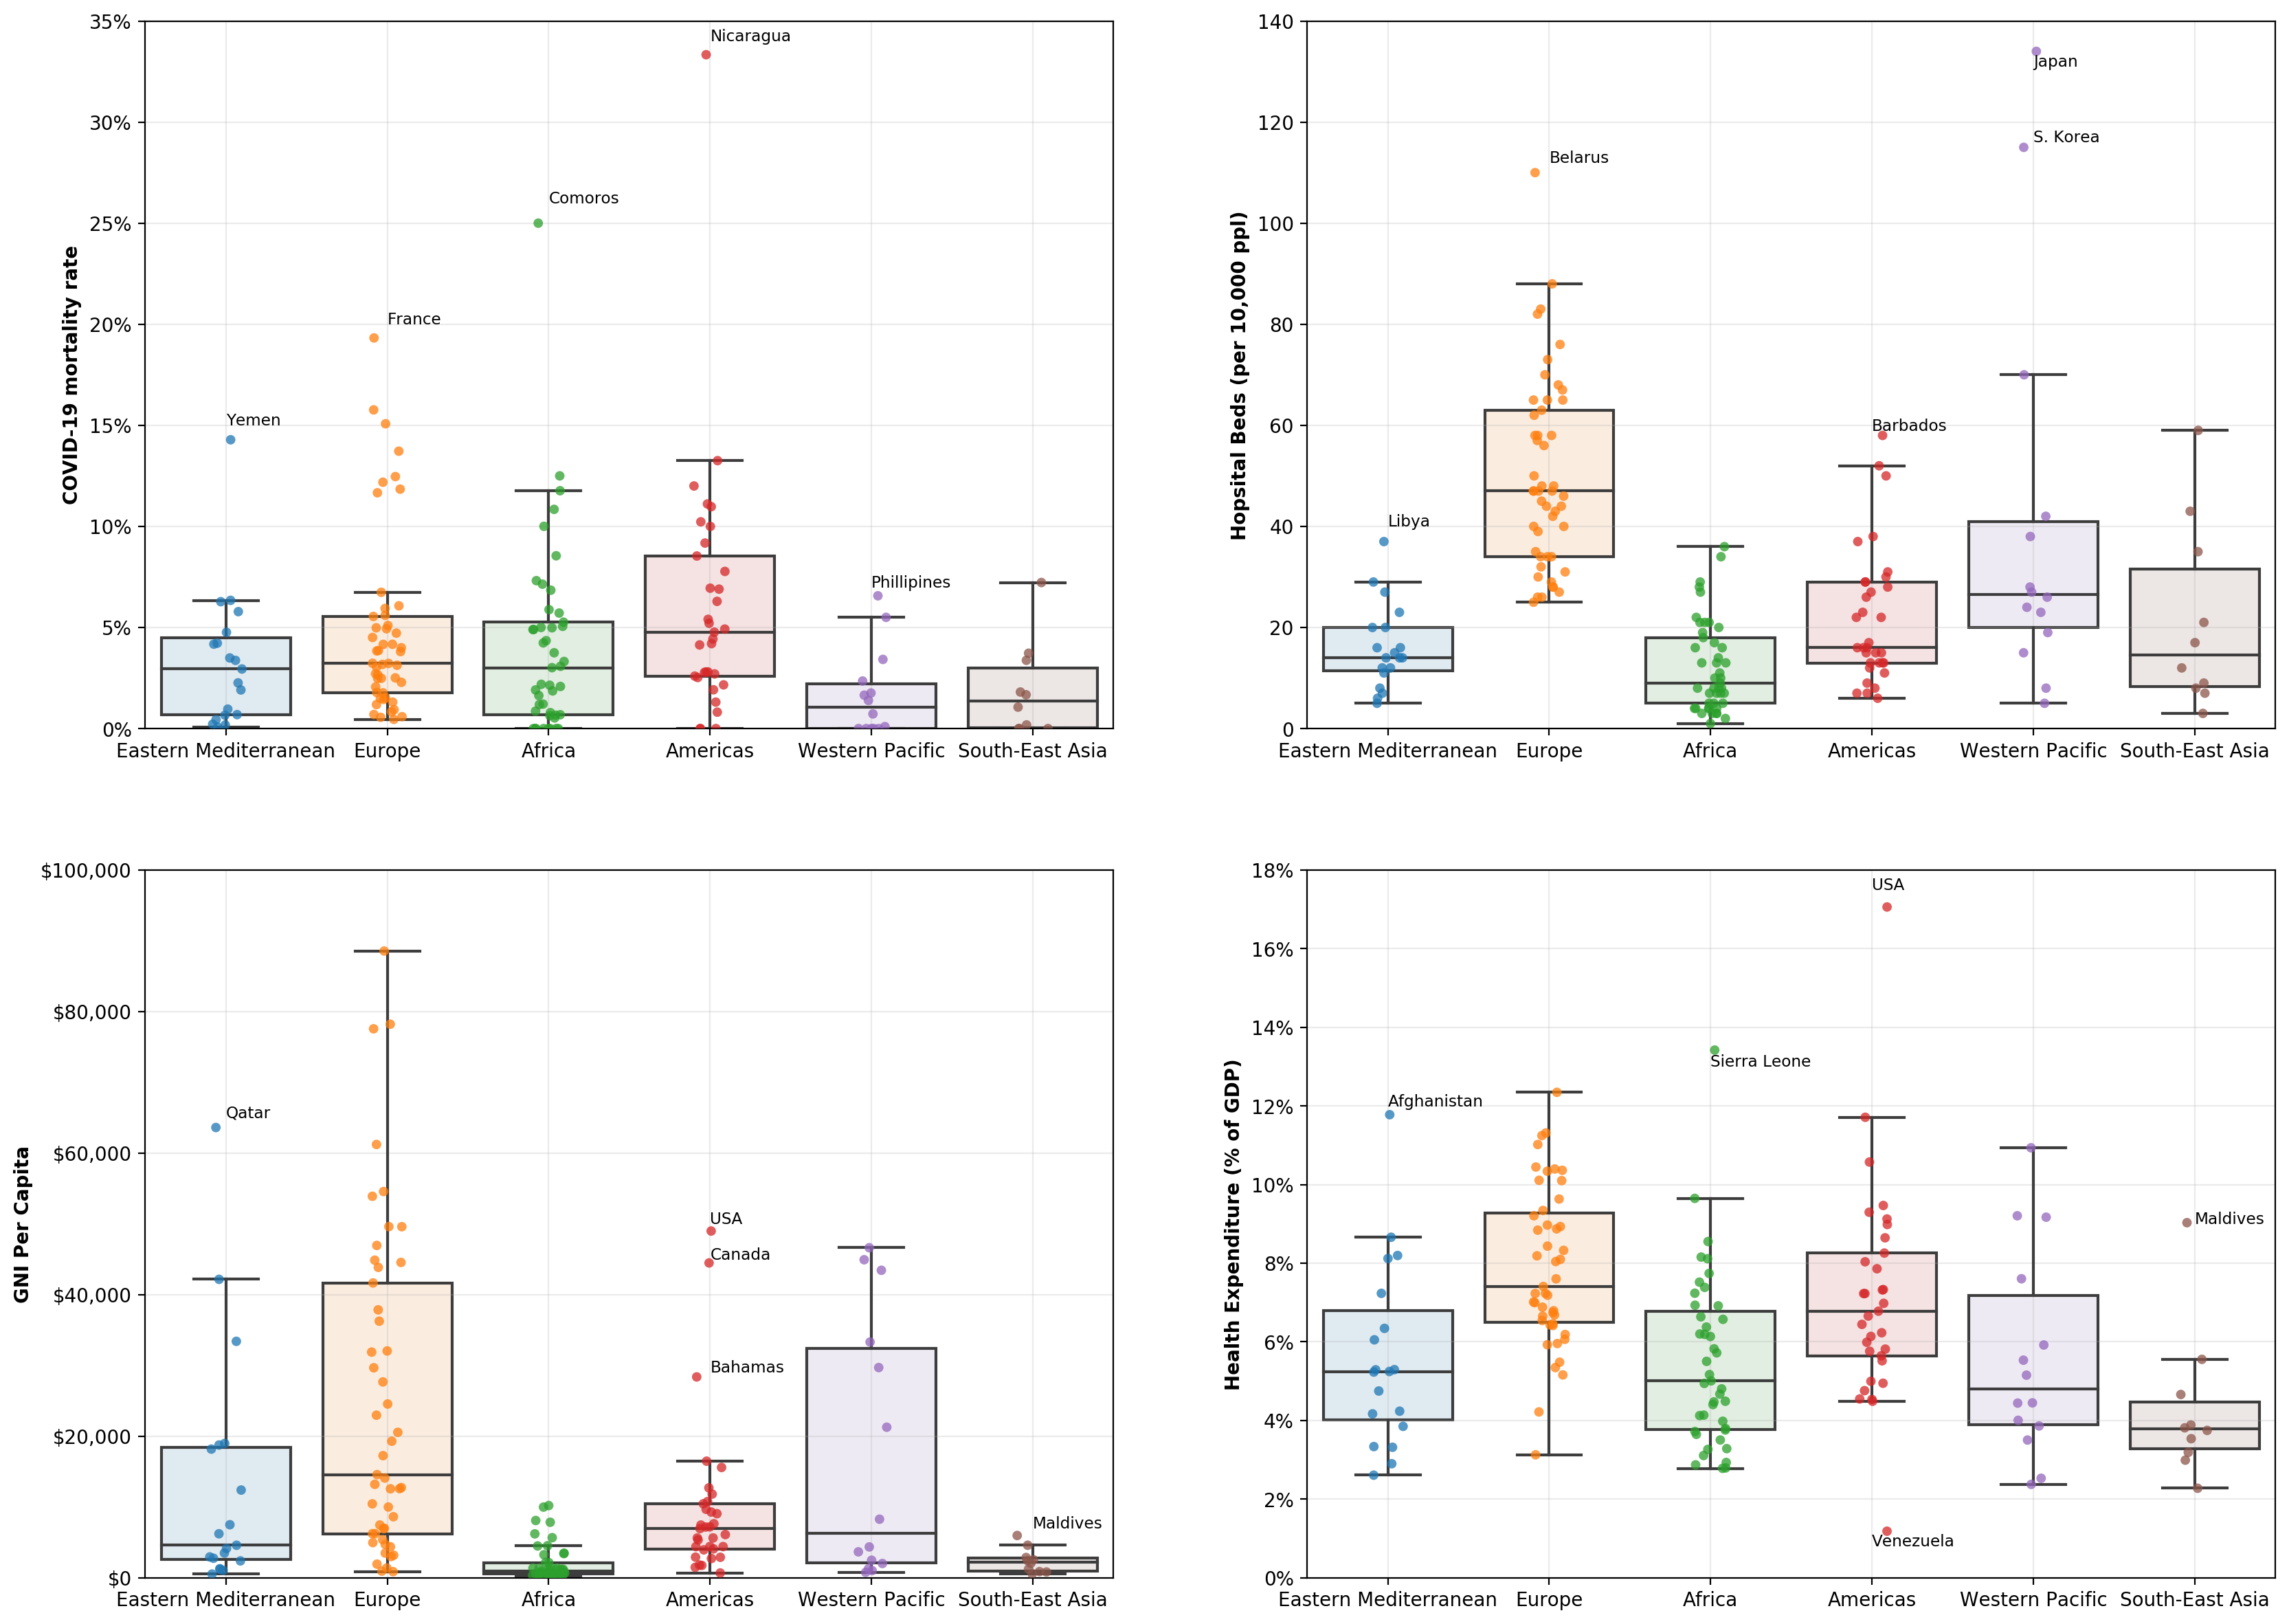

In [9]:
# Size the figure accordingly
# Create a plot grid with 2 columns and 2 rows
fig = plt.figure(num=None, figsize=(20, 15), dpi=200)

# Add COVID-19 Mortality Plot
ax1 = fig.add_subplot(221)
make_plots('Region','COVID Mortality Rate',"COVID-19 mortality rate",master_data,ax1,0.35)
## Format rate as percentage within y_label
vals = ax1.get_yticks()
ax1.set_yticklabels(['{:.0%}'.format(x) for x in vals])

# Add Hospital Bed Plot
ax2 = fig.add_subplot(222, sharex=ax1)
make_plots('Region','Hospital Beds',"Hopsital Beds (per 10,000 ppl)",master_data,ax2,140)

# Add Hospital GNI per Capita
ax3 = fig.add_subplot(223, sharex=ax1)
make_plots('Region','GNI Per Capita',"GNI Per Capita",master_data,ax3,100000)
## Add dollar sign and commas to y_label
vals = ax3.get_yticks()
ax3.set_yticklabels(['${:,.0f}'.format(x) for x in vals])

# Add Health Expenditure per GDP 
ax4 = fig.add_subplot(224, sharex=ax1)
make_plots('Region','Health Expenditure (% of GDP)',"Health Expenditure (% of GDP)",master_data,ax4,18)
## Add percentage to y_label
vals = ax4.get_yticks()
ax4.set_yticklabels(['{:.0f}%'.format(x) for x in vals])

# ==
# Label outliers (Manual)
# ==    
## COVID-19 Mortality
x_list = [0,1,2,3,4]
y_list = [0.15,0.2,0.26,0.34,0.07] 
labels = ["Yemen","France", "Comoros","Nicaragua","Phillipines"]
label_pts(ax1,x_list,y_list,labels)

## Hospital Beds
x_list = [0,1,3,4,4]
y_list = [40,112,59,116,131] 
labels = ["Libya","Belarus", "Barbados","S. Korea","Japan"]
label_pts(ax2,x_list,y_list,labels)

## GNI Per Capita   
x_list = [0,3,3,3,5]
y_list = [65000,50000,45000,29000,7000] 
labels = ["Qatar","USA", "Canada","Bahamas","Maldives"]
label_pts(ax3,x_list,y_list,labels)

## Health Expenditures  
x_list = [0,2,3,3,5]
y_list = [12,13,0.8,17.5,9] 
labels = ["Afghanistan","Sierra Leone", "Venezuela","USA","Maldives"]
label_pts(ax4,x_list,y_list,labels)  
    
# Save and display plot
fig_file_name = os.path.join(".","outputs/outliers.png")
plt.savefig(fig_file_name)
plt.show()

----
### Regression Analysis: Health Expenditures vs. Hospital Beds

In [10]:
# Grab data for scatter plot: hospital beds vs. health expenditure per capita (USD)
scatter1=master_data[["Hospital Beds","Health Expenditure per capita (current USD)"]]

# Drop NaN values from the dataset
scatter1=scatter1.dropna()
scatter1.head(3)

,Hospital Beds,Health Expenditure per capita (current USD)
0,5.0,67.122650
2,19.0,258.494293
3,8.0,114.459641


In [11]:
# Create the x and y data series for scatter plot
x_axis= scatter1["Hospital Beds"]
y_axis=scatter1["Health Expenditure per capita (current USD)"]

# Calculate pearson correlation coefficient (PCC) from the data set
Corr_Coeff=round(st.pearsonr(x_axis,y_axis)[0],2)

# Perform a linear regression on the dataset
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_axis, y_axis)
regression = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

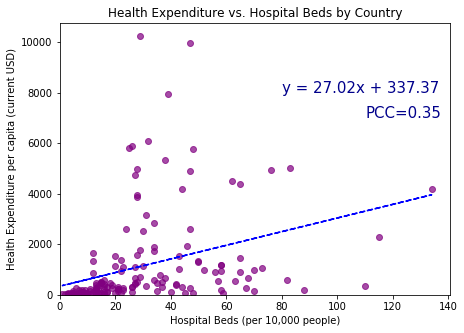

In [12]:
# Start a figure with desired dimensions
plt.figure(figsize=(7,5))

# Create the scatter plot: Health Expenditure vs. Hospital Beds by Country
plt.scatter(x_axis, y_axis,marker="o",color="purple",alpha=0.7)

# Format the scatter plot
plt.title("Health Expenditure vs. Hospital Beds by Country")
plt.ylabel("Health Expenditure per capita (current USD)")
plt.xlabel("Hospital Beds (per 10,000 people)")
plt.xlim(0)
plt.ylim(0)

# Overlay the regression line over the scatter
# Annotate line formula and pearson correlation coefficient (PCC)
plt.plot(x_axis,regression,"b--")
plt.annotate(line_eq,(80,8000),fontsize=15,color="darkblue")
plt.annotate(f"PCC={Corr_Coeff}",(110,7000),fontsize=15,color="darkblue")

# Save and display figure
fig_scatter1 = os.path.join("outputs/Health Exp vs Hospital Beds.png")
plt.savefig(fig_scatter1)
plt.show()

----
### Regression Analysis: COVID-19 Mortality Rate vs. Health Expenditures 

In [13]:
# Grab data for scatter plot: COVID-19 data & health expenditure per capita (USD)
scatter2=master_data[["CumCase","CumDeath","Health Expenditure (% of GDP)"]]

# Drop NaN values
scatter2=scatter2.dropna()
scatter2.head(3)

,CumCase,CumDeath,Health Expenditure (% of GDP)
0,3224.0,95.0,11.777194
2,4648.0,465.0,6.374322
3,35.0,2.0,2.791500


In [14]:
# Calculate COVID-19 mortality from collected # of cases and # of deaths
scatter2_df=pd.DataFrame({
    "Mortality Rate (%)":scatter2["CumDeath"]/scatter2["CumCase"]*100,
    "Health Expenditure (% of GDP)":scatter2["Health Expenditure (% of GDP)"]
})
scatter2_df.head(3)

,Mortality Rate (%),Health Expenditure (% of GDP)
0,2.946650,11.777194
2,10.004303,6.374322
3,5.714286,2.791500


In [15]:
# Create the x and y data series for scatter plot
x_axis= scatter2_df["Mortality Rate (%)"]
y_axis=scatter2_df["Health Expenditure (% of GDP)"]

# Calculate pearson correlation coefficient (PCC) from the data set
Corr_Coeff=round(st.pearsonr(x_axis,y_axis)[0],2)

# Perform a linear regression on the dataset
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_axis, y_axis)
regression = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

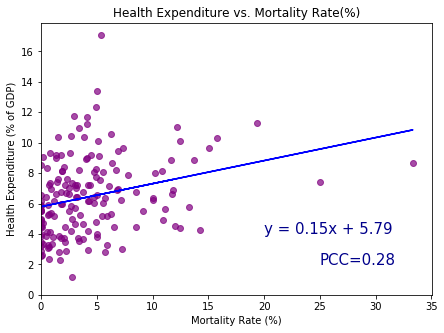

In [16]:
# Start a figure with desired dimensions
plt.figure(figsize=(7,5))

# Create the scatter plot Health Expenditure vs. Mortality Rate(%)
plt.scatter(x_axis, y_axis,marker="o",color="purple",alpha=0.7)

# Format scatter plot
plt.title("Health Expenditure vs. Mortality Rate(%)")
plt.ylabel("Health Expenditure (% of GDP)")
plt.xlabel("Mortality Rate (%)")
plt.xlim(0)
plt.ylim(0)

# Overlay the regression line over the scatter
# Annotate line formula and pearson correlation coefficient (PCC)
plt.plot(x_axis,regression,"b-")
plt.annotate(line_eq,(20,4),fontsize=15,color="darkblue")
plt.annotate(f"PCC={Corr_Coeff}",(25,2),fontsize=15,color="darkblue")

# Save figure and display
fig_scatter2 = os.path.join("outputs/Health Exp vs Mortality Rate1.png")
plt.savefig(fig_scatter2)
plt.show()

----
### Regression Analysis: COVID-19 Mortality Rate (%) vs. Hospital Beds

In [17]:
# Grab data for scatter plot: COVID-19 data & hospital bed
scatter3=master_data[["CumCase","CumDeath","Hospital Beds"]]

# Drop NaN values
scatter3=scatter3.dropna()
scatter3.head(3)

,CumCase,CumDeath,Hospital Beds
0,3224.0,95.0,5.0
1,803.0,31.0,29.0
2,4648.0,465.0,19.0


In [18]:
# Calculate COVID-19 mortality from collected # of cases and # of deaths
scatter3_df=pd.DataFrame({
    "Mortality Rate (%)":scatter3["CumDeath"]/scatter3["CumCase"]*100,
    "Hospital Beds":scatter3["Hospital Beds"]
})
scatter3_df.head(3)

,Mortality Rate (%),Hospital Beds
0,2.946650,5.0
1,3.860523,29.0
2,10.004303,19.0


In [19]:
# Create the x and y data series for scatter plot
x_axis=scatter3_df["Mortality Rate (%)"]
y_axis=scatter3_df["Hospital Beds"] 

# Calculate pearson correlation coefficient (PCC) from the data set
Corr_Coeff=round(st.pearsonr(x_axis,y_axis)[0],2)

# Perform a linear regression on the dataset
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_axis, y_axis)
regression = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

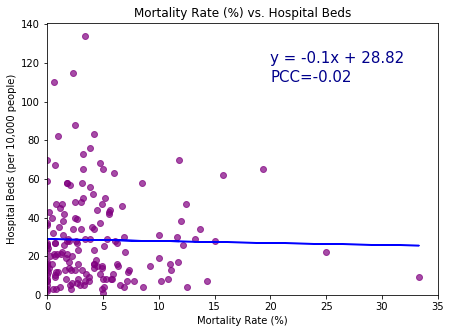

In [20]:
# Create a figure
plt.figure(figsize=(7,5))

# Create a scatterplot: Mortality Rate (%) vs. Hospital Beds
plt.scatter(x_axis, y_axis,marker="o",color="purple",alpha=0.7)

# Format scatter plot
plt.title("Mortality Rate (%) vs. Hospital Beds")
plt.ylabel("Hospital Beds (per 10,000 people)")
plt.xlabel("Mortality Rate (%)")
plt.xlim(0)
plt.ylim(0)

# Plot regression line and annotate with line formula and PCC
plt.plot(x_axis,regression,"b-")
plt.annotate(line_eq,(20,120),fontsize=15,color="darkblue")
plt.annotate(f"PCC={Corr_Coeff}",(20,110),fontsize=15,color="darkblue")

# Display plot
plt.show()

----
### Regression Analysis: COVID-19 Mortality Rate vs. GNI Per Capita

In [21]:
# Grab COVID and GNI per Capita data from master CSV 
scatter4=master_data[["CumCase","CumDeath","GNI Per Capita"]]

# Drop NaN values from the dataset
scatter4=scatter4.dropna()
scatter4.head(3)

,CumCase,CumDeath,GNI Per Capita
0,3224.0,95.0,510.0
1,803.0,31.0,4360.0
2,4648.0,465.0,4480.0


In [22]:
# Calculate COVID-19 mortality from collected # of cases and # of deaths
scatter4_df=pd.DataFrame({
    "Mortality Rate (%)":scatter4["CumDeath"]/scatter4["CumCase"]*100,
    "GNI Per Capita ($)":scatter4["GNI Per Capita"]
})
scatter4_df.head(3)

,Mortality Rate (%),GNI Per Capita ($)
0,2.946650,510.0
1,3.860523,4360.0
2,10.004303,4480.0


In [23]:
# Create the x and y data series for scatter plot
x_axis=scatter4_df["Mortality Rate (%)"]
y_axis=scatter4_df["GNI Per Capita ($)"] 

# Calculate pearson correlation coefficient (PCC) from the data set
Corr_Coeff=round(st.pearsonr(x_axis,y_axis)[0],2)

# Perform a linear regression on the dataset
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_axis, y_axis)
regression = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

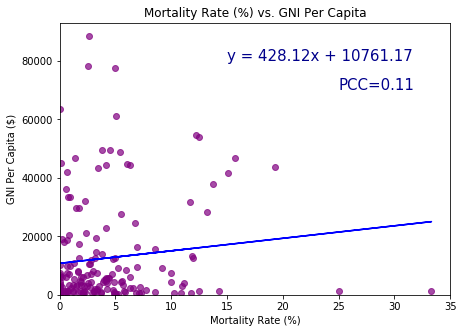

In [24]:
# Create a figure
plt.figure(figsize=(7,5))

# Create scatter plot: Mortality Rate (%) vs. GNI Per Capita
plt.scatter(x_axis, y_axis,marker="o",color="purple",alpha=0.7)

# Format scatter plot
plt.title("Mortality Rate (%) vs. GNI Per Capita")
plt.ylabel("GNI Per Capita ($)")
plt.xlabel("Mortality Rate (%)")
plt.xlim(0)
plt.ylim(0)

# Plot regression line and annotate with line formula and PCC
plt.plot(x_axis,regression,"b-")
plt.annotate(line_eq,(15,80000),fontsize=15,color="darkblue")
plt.annotate(f"PCC={Corr_Coeff}",(25,70000),fontsize=15,color="darkblue")

# Display plot
plt.show()

----
### Bubble chart: Comparing COVID-19 mortality, Health Expenditures, GNI per capita

In [25]:
# Pull data required for bubble chart
bubble=master_data[["Code","GNI Per Capita","CumCase","CumDeath","Health Expenditure (% of GDP)"]]

# Set dataframe index to country code
bubble=bubble.set_index("Code")
bubble.head(3)

,GNI Per Capita,CumCase,CumDeath,Health Expenditure (% of GDP)
Code,,,,
AFG,510.0,3224.0,95.0,11.777194
ALB,4360.0,803.0,31.0,NaN
DZA,4480.0,4648.0,465.0,6.374322


In [26]:
# Create color pallete for bubble chart using number randomizer
N = 170
colors = np.random.rand(N)

In [27]:
# Create dataframe for bubble chart, appending a color for each country
bubble_df=pd.DataFrame({
    "Mortality Rate (%)":bubble["CumDeath"]/bubble["CumCase"]*100,
    "Health Expenditure (% of GDP)":bubble["Health Expenditure (% of GDP)"],
    "GNI per Capita":bubble["GNI Per Capita"]/100,
    "colors":colors
})

# Drop any NaN values
bubble_df=bubble_df.dropna()
bubble_df.head(3)

,Mortality Rate (%),Health Expenditure (% of GDP),GNI per Capita,colors
Code,,,,
AFG,2.946650,11.777194,5.1,0.984208
DZA,10.004303,6.374322,44.8,0.009337
AGO,5.714286,2.791500,32.4,0.386535


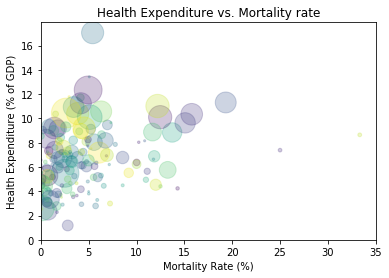

<Figure size 1440x1440 with 0 Axes>

In [28]:
# Create bubble plot: Mortality v. Health Expenditures
# each country point sized by GNI per Capita
plt.scatter('Mortality Rate (%)', 'Health Expenditure (% of GDP)', s=('GNI per Capita'),c='colors', alpha=0.25, data=bubble_df)

# Format the plot
plt.title("Health Expenditure vs. Mortality rate")
plt.xlabel("Mortality Rate (%)")
plt.ylabel("Health Expenditure (% of GDP)")
plt.xlim(0)
plt.ylim(0)

# Size the plot accordingly
plt.figure(figsize=(20,20))

# Save and display figure
fig_bubble = os.path.join("outputs/Health Exp vs Mortality Rate2.png")
plt.savefig(fig_bubble)
plt.show()

----
### Regional Distribution of Hospital Beds

In [29]:
# Guardar una copia local de master_data
Master_df = master_data

#Elimino los NA
Master_df = Master_df.dropna()
Master_df.head()

,Country,Code,Region,Location,Hospital Beds,GNI Per Capita,CumCase,CumDeath,IncomeGroup,Health Expenditure per capita (current USD),Health Expenditure (% of GDP),COVID Mortality Rate
0,Afghanistan,AFG,Eastern Mediterranean,"[33.0, 65.0]",5.0,510.0,3224.0,95.0,Low income,67.122650,11.777194,0.02947
2,Algeria,DZA,Africa,"[28.0, 3.0]",19.0,4480.0,4648.0,465.0,Upper middle income,258.494293,6.374322,0.10004
3,Angola,AGO,Africa,"[-12.5, 18.5]",8.0,3240.0,35.0,2.0,Lower middle income,114.459641,2.791500,0.05714
4,Antigua and Barbuda,ATG,Americas,"[17.05, -61.8]",38.0,12690.0,25.0,3.0,High income,673.859680,4.533532,0.12000
5,Argentina,ARG,Americas,"[-34.0, -64.0]",50.0,9270.0,4799.0,250.0,Upper middle income,1324.603516,9.124315,0.05209


In [30]:
#Se crea DF para separar por Regiones
CountRe_df = Master_df.groupby(["Region"])[["Hospital Beds"]].count()
CountRe_df = CountRe_df.rename(columns={'Hospital Beds':'Count Samples'})
CountHB_df = Master_df.groupby(["Region"])[["Hospital Beds"]].sum()
CountGNI_df = Master_df.groupby(["Region"])[["GNI Per Capita"]].mean()
CountCase_df = Master_df.groupby(["Region"])[["CumCase"]].sum()
CountDeath_df = Master_df.groupby(["Region"])[["CumDeath"]].sum()
CountExpUSD_df = Master_df.groupby(["Region"])[["Health Expenditure per capita (current USD)"]].mean()
CountExpGDP_df = Master_df.groupby(["Region"])[["Health Expenditure (% of GDP)"]].mean()
Region_df = pd.concat([CountRe_df, CountHB_df, CountGNI_df, CountCase_df, CountDeath_df, CountExpUSD_df, CountExpGDP_df], axis=1)
Region_df

,Count Samples,Hospital Beds,GNI Per Capita,CumCase,CumDeath,Health Expenditure per capita (current USD),Health Expenditure (% of GDP)
Region,,,,,,,
Africa,43,515.0,2159.302326,29818.0,1086.0,128.161500,5.497244
Americas,33,724.0,9751.212121,1474564.0,79977.0,1039.754176,7.136474
Eastern Mediterranean,19,306.0,12913.684211,218410.0,8199.0,545.642957,5.609777
Europe,47,2391.0,25537.872340,1562004.0,145388.0,2360.932833,7.877971
South-East Asia,10,214.0,2378.000000,74007.0,2692.0,191.996219,4.266730
Western Pacific,14,574.0,17354.285714,153626.0,6280.0,1469.999475,5.619178


In [31]:
#Agregamos Index para poder trabajar las tablas
Region_df = Region_df.reset_index()
Region_df

,Region,Count Samples,Hospital Beds,GNI Per Capita,CumCase,CumDeath,Health Expenditure per capita (current USD),Health Expenditure (% of GDP)
0,Africa,43,515.0,2159.302326,29818.0,1086.0,128.161500,5.497244
1,Americas,33,724.0,9751.212121,1474564.0,79977.0,1039.754176,7.136474
2,Eastern Mediterranean,19,306.0,12913.684211,218410.0,8199.0,545.642957,5.609777
3,Europe,47,2391.0,25537.872340,1562004.0,145388.0,2360.932833,7.877971
4,South-East Asia,10,214.0,2378.000000,74007.0,2692.0,191.996219,4.266730
5,Western Pacific,14,574.0,17354.285714,153626.0,6280.0,1469.999475,5.619178


In [32]:
#Se obtiene la lista del Count Samples para poder iterar en la grafica de barras.
Contar = Region_df["Count Samples"].to_list()
Contar

[43, 33, 19, 47, 10, 14]

In [33]:
#Se pretendia dar formato al DF pero si se hacia las graficas y el resto de operaciones no funcionaban.
#Region_df = Region_df.style.format({'Hospital Beds': "{:.0f}",
#                                    'GNI Per Capita': "{:,.0f}",
#                                    'CumCase': "{:,.0f}",
#                                    'CumDeath': "{:,.0f}",
#                                    'Health Expenditure per capita (current USD)': "{:,.0f}",
#                                    'Health Expenditure (% of GDP)': "{:,.2f}"})
#Region_df

In [34]:
#Se crea DF para separar por Income
ICountRe_df = Master_df.groupby(["IncomeGroup"])[["Hospital Beds"]].count()
ICountRe_df = ICountRe_df.rename(columns={'Hospital Beds':'Count Samples'})
ICountHB_df = Master_df.groupby(["IncomeGroup"])[["Hospital Beds"]].sum()
ICountGNI_df = Master_df.groupby(["IncomeGroup"])[["GNI Per Capita"]].mean()
ICountCase_df = Master_df.groupby(["IncomeGroup"])[["CumCase"]].sum()
ICountDeath_df = Master_df.groupby(["IncomeGroup"])[["CumDeath"]].sum()
ICountExpUSD_df = Master_df.groupby(["IncomeGroup"])[["Health Expenditure per capita (current USD)"]].mean()
ICountExpGDP_df = Master_df.groupby(["IncomeGroup"])[["Health Expenditure (% of GDP)"]].mean()
Income_df = pd.concat([ICountRe_df, ICountHB_df, ICountGNI_df, ICountCase_df, ICountDeath_df, ICountExpUSD_df, ICountExpGDP_df], axis=1)
Income_df

,Count Samples,Hospital Beds,GNI Per Capita,CumCase,CumDeath,Health Expenditure per capita (current USD),Health Expenditure (% of GDP)
IncomeGroup,,,,,,,
High income,52,2237.0,33348.653846,2575104.0,206568.0,3003.478943,7.838424
Low income,27,216.0,594.074074,10437.0,345.0,39.558440,6.151407
Lower middle income,38,758.0,1866.052632,149624.0,5337.0,117.352421,5.036746
Upper middle income,49,1513.0,6243.673469,777264.0,31372.0,447.866766,6.224264


In [35]:
#Se acomoda el Data frame para que tenga estructura de High Income a Low Income.
Income_df = Income_df.reindex(['High income', 'Upper middle income', 'Lower middle income', 'Low income'])

#Se elimina el Index para poder trabajar la tabla en las graficas
Income_df = Income_df.reset_index()
Income_df

,IncomeGroup,Count Samples,Hospital Beds,GNI Per Capita,CumCase,CumDeath,Health Expenditure per capita (current USD),Health Expenditure (% of GDP)
0,High income,52,2237.0,33348.653846,2575104.0,206568.0,3003.478943,7.838424
1,Upper middle income,49,1513.0,6243.673469,777264.0,31372.0,447.866766,6.224264
2,Lower middle income,38,758.0,1866.052632,149624.0,5337.0,117.352421,5.036746
3,Low income,27,216.0,594.074074,10437.0,345.0,39.558440,6.151407


In [36]:
#Se pretendia dar formato al DF pero si se hacia las graficas y el resto de operaciones no funcionaban.
#Income_df = Income_df.style.format({'Hospital Beds': "{:.0f}",
#                                    'GNI Per Capita': "{:,.0f}",
#                                    'CumCase': "{:,.0f}",
#                                    'CumDeath': "{:,.0f}",
#                                    'Health Expenditure per capita (current USD)': "{:,.0f}",
#                                    'Health Expenditure (% of GDP)': "{:,.0f}"})
#Income_df

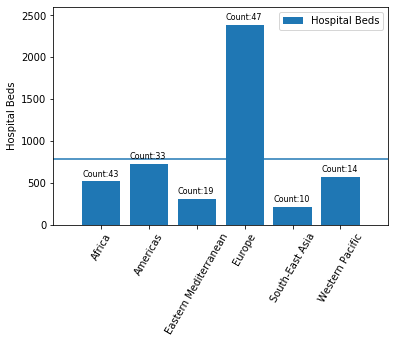

In [37]:
#Se genera la grafica de barras con Media y mostrando las muestras obtenidas.
plt.bar(Region_df["Region"], Region_df["Hospital Beds"])

# Agrega formato
plt.xticks(label="Regions", rotation="60")
plt.legend(["Hospital Beds"])
plt.ylabel("Hospital Beds")
plt.xlim(-1, 6)
plt.ylim(0,2600)

# Linea horizontal
mean = Region_df["Hospital Beds"].mean()
plt.axhline(mean) # EXTRA

# Anota el gráfico
for i in range(len(Contar)):
    plt.text(x =i-0.4 , y = Region_df["Hospital Beds"][i]+60, s = f"Count:{Contar[i]}", size = 8)

# Genera figura y guarda imagen
fig_name = os.path.join("outputs/HB vs Regions wSamples.png")
plt.savefig(fig_name)
plt.show()

In [38]:
#Se hace DF del promedio de camas para cada region
AveHB = Region_df.filter(['Region_x','Count Samples','Hospital Beds'], axis=1)
AveHB["Average Beds"] = AveHB["Hospital Beds"]/AveHB["Count Samples"]

AveHB = AveHB.style.format({'Count Samples': "{:.0f}",
                                    'Hospital Beds': "{:,.0f}",
                                    'Average Beds': "{:,.2f}%",
                            })


AveHB

,Count Samples,Hospital Beds,Average Beds
0,43,515,11.98%
1,33,724,21.94%
2,19,306,16.11%
3,47,"2,391",50.87%
4,10,214,21.40%
5,14,574,41.00%


----
### Group View: Hospital Beds vs. COVID Cases/Deaths

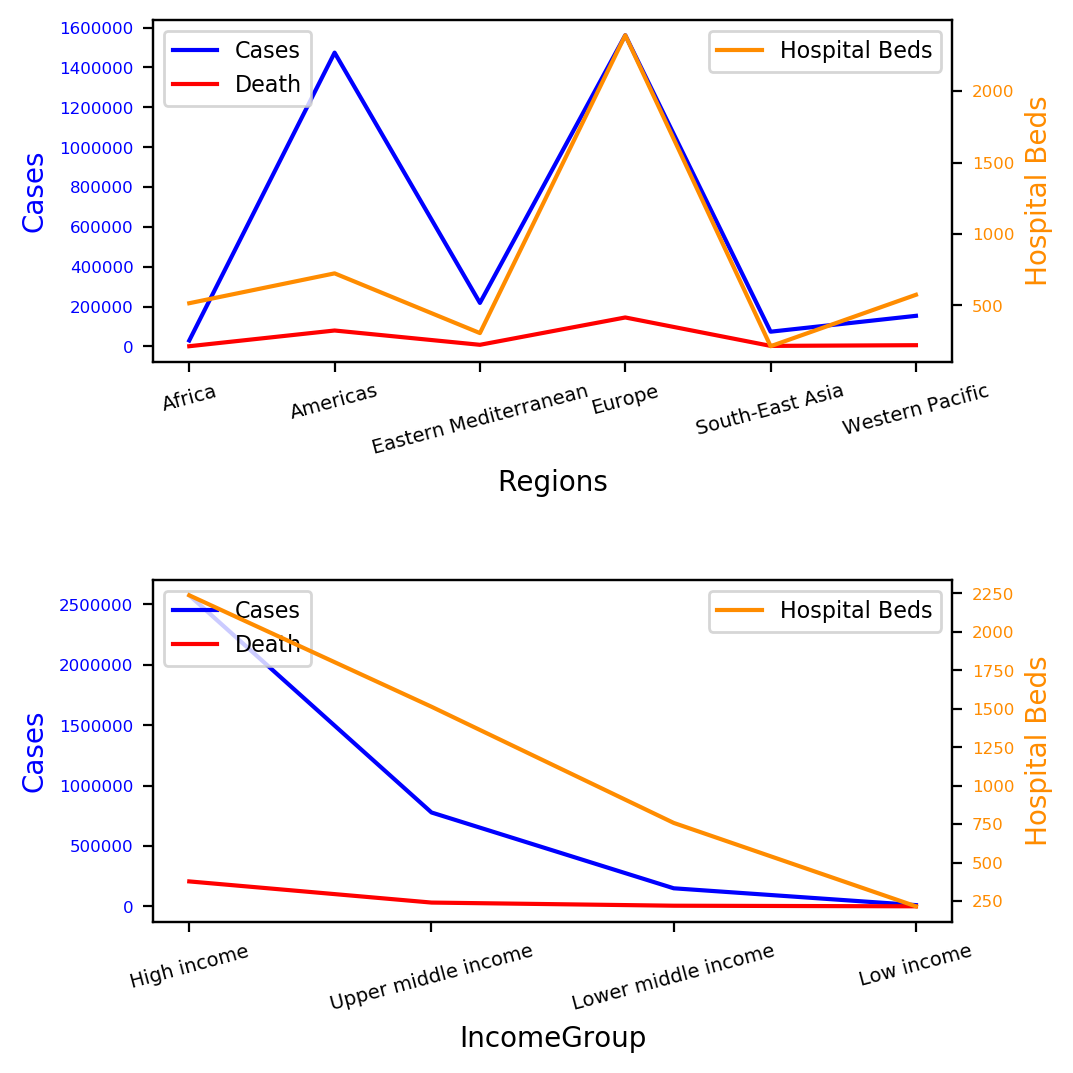

In [39]:
#Se hace una grafica de 3 ejes dado que los montos con los que se quiere comparar, son mas 
#completamente diferentes en proporcion y se hace el codigo para que se 
#reflejen dos graficas en el mismo espacio.

# Crea figura con las siguientes proporciones
fig = plt.figure(num=None, figsize=(6, 6), dpi=200)

# Subplots (2 filas, 1 columna, 1er subplot)
ax5 = fig.add_subplot(211)

# Line plots
ax5.plot(Region_df["Region"],
         Region_df["CumCase"], 
         color="blue", label="Cases")
ax5.plot(Region_df["Region"],
         Region_df["CumDeath"],
         color="red",
         label="Death")

# Agrega formato
ax5.set_xlabel('Regions')
ax5.set_ylabel("Cases", 
               color="blue")
ax5.tick_params(axis='y',
                labelcolor="blue",
                labelsize=6
               )
plt.xticks(rotation="15")
plt.tick_params(axis='x', labelsize=7)
plt.legend(loc="upper left", fontsize=8)

ax6 = ax5.twinx()  # instantiate a second axes that shares the same x-axis

# Line plot
ax6.plot(Region_df["Region"],
         Region_df["Hospital Beds"],
         color="darkorange",
         label="Hospital Beds")

# Agrega formato
ax6.set_ylabel("Hospital Beds", 
               color="darkorange")  # we already handled the x-label with ax1
ax6.tick_params(axis='y', 
                labelcolor="darkorange",
                labelsize=6,
               )
plt.xticks(rotation="15")
plt.legend(loc="upper right", fontsize=8)

############# FIN Primer Plot #############

# Subplots (2 filas, 1 columna, 2do subplot)
ax7 = fig.add_subplot(212)

# Line plots
ax7.plot(Income_df["IncomeGroup"],
         Income_df["CumCase"], 
         color="blue", 
         label="Cases")
ax7.plot(Income_df["IncomeGroup"],
         Income_df["CumDeath"],
         color="red",
         label="Death")

# Agrega formato
ax7.set_xlabel('IncomeGroup')
ax7.set_ylabel("Cases", 
               color="blue")
ax7.tick_params(axis='y',
                labelcolor="blue",
                labelsize=6
               )
plt.xticks(rotation="15")
plt.tick_params(axis='x', 
                labelsize=7)
plt.legend(loc="upper left", 
           fontsize=8)


ax8 = ax7.twinx()  # instantiate a second axes that shares the same x-axis

# Line plot
ax8.plot(Income_df["IncomeGroup"],
         Income_df["Hospital Beds"],
         color="darkorange",
         label="Hospital Beds",
        )

# Agrega formato
ax8.set_ylabel("Hospital Beds", 
               color="darkorange"
              )  # we already handled the x-label with ax1
ax8.tick_params(axis='y', 
                labelcolor="darkorange",
                labelsize=6,
               )
plt.xticks(rotation="15")
plt.legend(loc="upper right", fontsize=8)
plt.tight_layout(pad=3.0)


# Genera figura y guarda imagen
fig_name = os.path.join("outputs/HB vs Cases.png")
plt.savefig(fig_name)
plt.show()

----
### Group View: GNI Per Capita vs. COVID Cases/Deaths

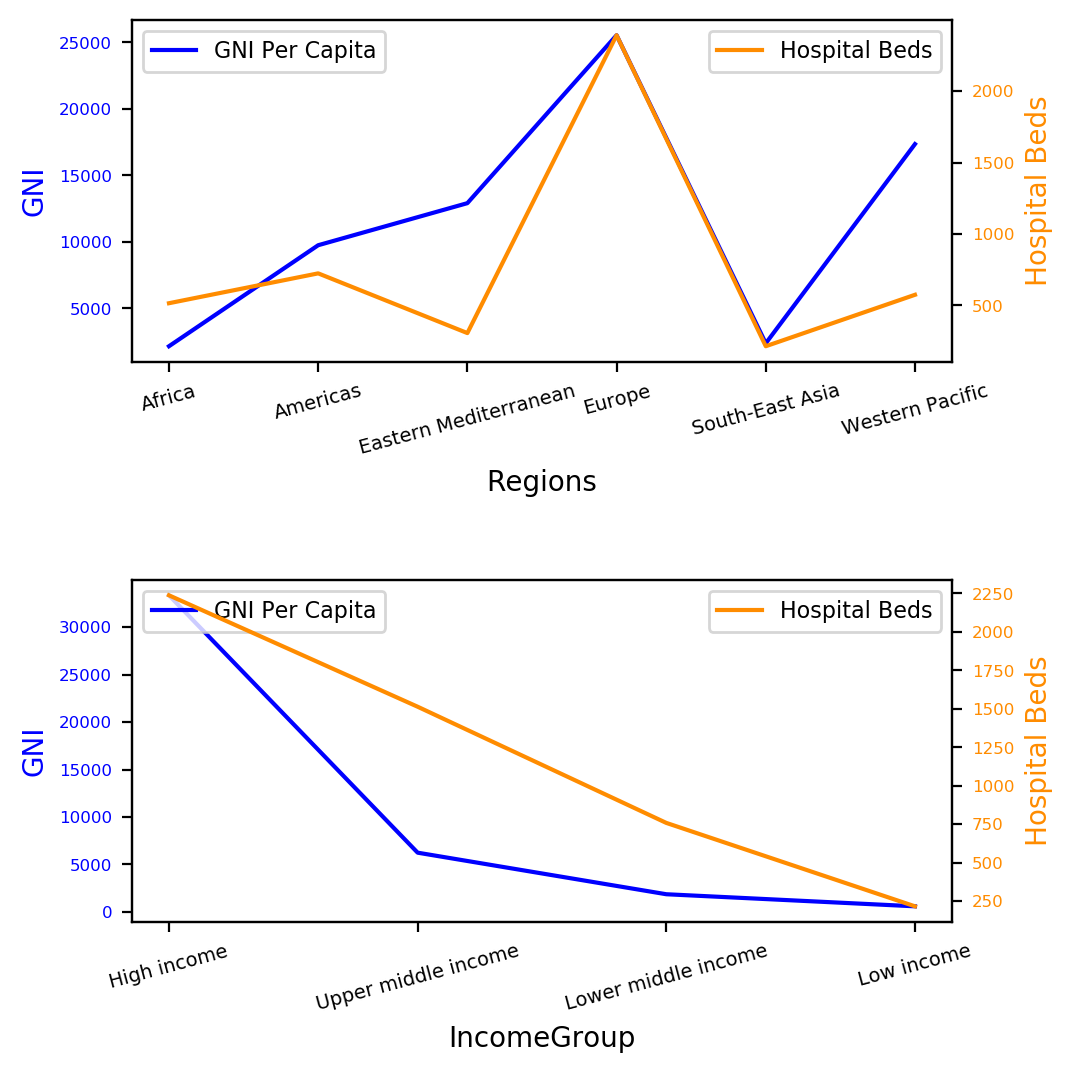

In [40]:
#Se hace una grafica de 3 ejes dado que los montos con los que se quiere comparar, son mas 
#completamente diferentes en proporcion y se hace el codigo para que se 
#reflejen dos graficas en el mismo espacio.

# Crea figura con las siguientes proporciones
fig = plt.figure(num=None, figsize=(6, 6), dpi=200)

# Subplots (2 filas, 1 columna, 1er subplot)
ax15 = fig.add_subplot(211)

# Line plot
ax15.plot(Region_df["Region"],
         Region_df["GNI Per Capita"], 
         color="blue", label="GNI Per Capita")

# Agrega formato
ax15.set_xlabel('Regions')
ax15.set_ylabel("GNI", 
               color="blue")
#ax15.plot(Region_df["Region_x"],
#         Region_df["CumDeath"],
#         color="orange",
#         label="Death")
ax15.tick_params(axis='y',
                labelcolor="blue",
                labelsize=6
               )
plt.xticks(rotation="15")
plt.tick_params(axis='x', 
                labelsize=7)
plt.legend(loc="upper left", 
           fontsize=8)

ax16 = ax15.twinx()  # instantiate a second axes that shares the same x-axis

# Line plot
ax16.plot(Region_df["Region"],
         Region_df["Hospital Beds"],
         color="darkorange",
         label="Hospital Beds")

# Agrega formato
ax16.set_ylabel("Hospital Beds", 
               color="darkorange")  # we already handled the x-label with ax1
ax16.tick_params(axis='y', 
                labelcolor="darkorange",
                labelsize=6,
               )
plt.xticks(rotation="15")
plt.legend(loc="upper right", fontsize=8)

############# FIN Primer Plot #############

# Subplots (2 filas, 1 columna, 2do subplot)
ax17 = fig.add_subplot(212)

# Line plot
ax17.plot(Income_df["IncomeGroup"],
         Income_df["GNI Per Capita"], 
         color="blue",
          label="GNI Per Capita")

# Agrega formato
ax17.set_xlabel('IncomeGroup')
ax17.set_ylabel("GNI", 
               color="blue")
ax17.tick_params(axis='y',
                labelcolor="blue",
                labelsize=6
               )
plt.xticks(rotation="15")
plt.tick_params(axis='x', labelsize=7)
plt.legend(loc="upper left", fontsize=8)

ax18 = ax17.twinx()  # instantiate a second axes that shares the same x-axis

# Line plot
ax18.plot(Income_df["IncomeGroup"],
         Income_df["Hospital Beds"],
         color="darkorange",
         label="Hospital Beds",
        )
# Agrega formato
ax18.set_ylabel("Hospital Beds", 
               color="darkorange"
              )  # we already handled the x-label with ax1
ax18.tick_params(axis='y', 
                labelcolor="darkorange",
                labelsize=6,
               )
plt.xticks(rotation="15")
plt.legend(loc="upper right", fontsize=8)
plt.tight_layout(pad=3.0)

# Genera figura y guarda imagen
fig_name = os.path.join("outputs/GNI vs HB.png")
plt.savefig(fig_name)
plt.show()

----
### Micro-level Correlation Matrix

In [41]:
# Create the correlation matrix template: 
income_grps = list(master_data["IncomeGroup"].unique())
regions = list(master_data["Region"].unique())
indic = ["Hospital Beds","GNI Per Capita","Health Expenditure (% of GDP)"]

corrMatrix = pd.DataFrame(index=income_grps,columns = indic)
regCorrMatrix = pd.DataFrame(index=regions,columns = indic)
corrMatrix = corrMatrix.append(regCorrMatrix)

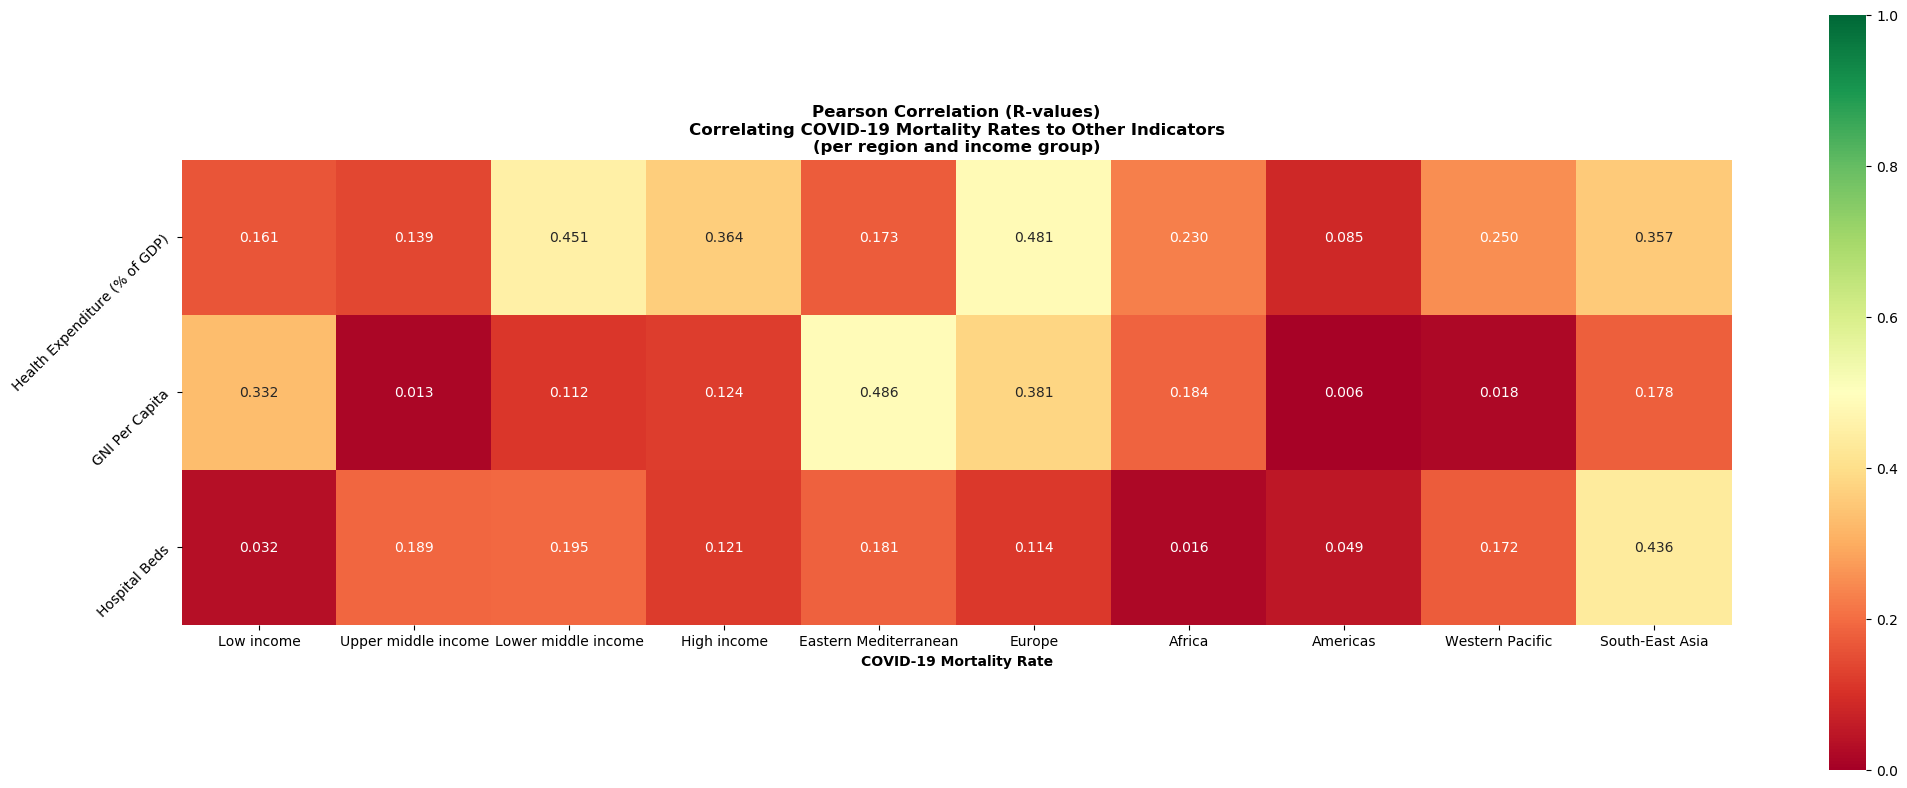

Strength of Association Key:
r < 0.3 | None
r = [0.3,0.5] | Weak
r = [0.5,0.7] | Moderate
r >= 0.7 | Strong
 


,Hospital Beds,GNI Per Capita,Health Expenditure (% of GDP)
Low income,-0.032,0.332,0.161
Upper middle income,-0.189,-0.013,0.139
Lower middle income,-0.195,-0.112,0.451
High income,0.121,0.124,0.364
Eastern Mediterranean,-0.181,-0.486,0.173
Europe,-0.114,0.381,0.481
Africa,-0.016,-0.184,0.230
Americas,-0.049,0.006,0.085
Western Pacific,0.172,-0.018,0.250
South-East Asia,-0.436,-0.178,-0.357


In [42]:
# Populate the Pearson correlation r-values for specified x and y values grouped by either
# income group or region
for i in indic:
    for grp in income_grps:

        # Gather x and y parameters from desired income group
        x_values = master_data.loc[master_data["IncomeGroup"] == grp][i]
        y_values = master_data.loc[master_data["IncomeGroup"] == grp]["COVID Mortality Rate"]

        # Create a mask to only use data points that have x and y non-NaN values (~ = NOT), 
        # or else regression analysis yields NaN vlaues for 
        mask = ~np.isnan(x_values) & ~np.isnan(y_values)

        # Perform linear regression
        rvalue = st.pearsonr(x_values[mask],y_values[mask])
        corrMatrix.loc[grp,i] = round(rvalue[0],3)
        
    for grp in regions:
        # Gather x and y parameters from desired region
        x_values = master_data.loc[master_data["Region"] == grp][i]
        y_values = master_data.loc[master_data["Region"] == grp]["COVID Mortality Rate"]

        # Create a mask to only use data points that have x and y non-NaN values (~ = NOT), 
        # or else regression analysis yields NaN vlaues for 
        mask = ~np.isnan(x_values) & ~np.isnan(y_values)

        # Perform linear regression
        rvalue = st.pearsonr(x_values[mask],y_values[mask])
        corrMatrix.loc[grp,i] = round(rvalue[0],3)
        
# Convert r values into floats (st.pearson returns strings by default)
corrMatrix = corrMatrix.astype(float)

# Create a figure with the following characteristics
fig = plt.figure(figsize=(25, 10),dpi=100)

# Make a seaborn heatmap, using a colorbar denoting r-values 0.0 to 1.0
sns.heatmap(abs(corrMatrix.T),cmap="RdYlGn",square= True, annot= True,fmt = '.3f',vmin = 0, vmax=1)

# Format/label the plot
plt.ylim(0,len(indic))
plt.yticks(rotation=45)
plt.title('Pearson Correlation (R-values)\nCorrelating COVID-19 Mortality Rates to Other Indicators\n(per region and income group)',fontweight="bold")
plt.xlabel("COVID-19 Mortality Rate",fontweight="bold")

# Save PNG and pring plot to screen
fig_file_name = os.path.join(".","outputs/rvalue_matrix.png")
plt.savefig(fig_file_name)
plt.show()

# Print correlation key (as a reminder to user)
print("\033[1mStrength of Association Key:\033[0m\nr < 0.3 | None\nr = [0.3,0.5] | Weak\nr = [0.5,0.7] | Moderate\nr >= 0.7 | Strong\n ")

# Print correlation matrix without Seaborn magic
corrMatrix